## Семинар №2. Нормализующие потоки, NICE, RealNVP


### План📝:

- #### Нормализующие потоки
- #### Модель NICE
- #### Модель RealNVP

In [ ]:
from enum import IntEnum

import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Uniform, SigmoidTransform, AffineTransform, TransformedDistribution
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm

from IPython.display import clear_output

В задачах генеративного моделирования нашей конечной целью является научиться моделировать неизвестное распределение реальных данных $p_{data}(\mathbf{x})$. Для этого мы обучаем собственное распределение $p_{\boldsymbol{\theta}}(\mathbf{x})$, чтобы оно было как можно ближе к истинному распределению, где $\boldsymbol{\theta}$ — параметры нашей нейросети.

## Нормализующие потоки

В нормализующих потоках для построения $p_{\boldsymbol{\theta}}(\mathbf{x})$ мы определяем некоторое обратимое и дифференцируемое преобразование $\boldsymbol{f}_{\boldsymbol{\theta}}(\mathbf{x})$, которое отображает исходный объект $\mathbf{x}$ из сложного пространства в более простое латентное пространство $\mathbf{z}$. В этом латентном пространстве переменная $\mathbf{z}$ подчиняется простому и заранее выбранному распределению $p(\mathbf{z})$.

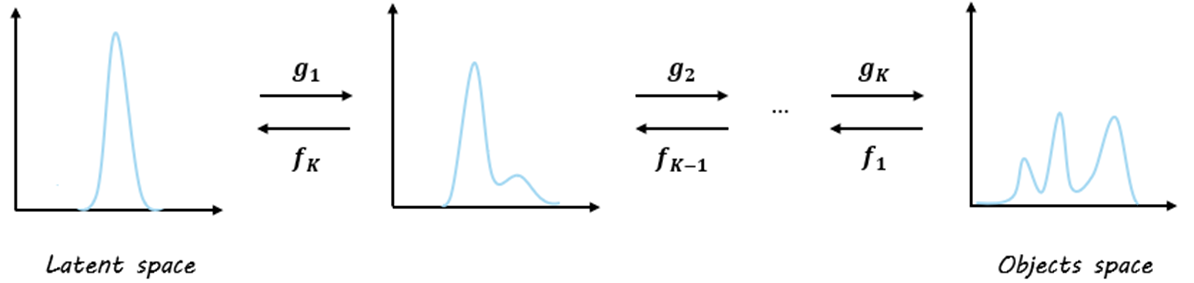

Используя формулу замены переменных, мы можем выразить плотность вероятности $p_{\boldsymbol{\theta}}(\mathbf{x})$ через плотность $p(\mathbf{z})$ и преобразование $\boldsymbol{f}_{\boldsymbol{\theta}}$ следующим образом:

$$p_{\boldsymbol{\theta}}(\mathbf{x}) = p(\boldsymbol{f}_{\boldsymbol{\theta}}(\mathbf{x})) \bigg| \det\left(\frac{\partial\boldsymbol{f_{\boldsymbol{\theta}}}​}{\partial \mathbf{x}} \right) \bigg|$$

### Композиция преобразований

Преобразование $\boldsymbol{f}_{\boldsymbol{\theta}}$ в нормализующих потоках обычно строится как композиция $K$ простых, обратимых и дифференцируемых слоев $\boldsymbol{f}_{\boldsymbol{\theta}} = \boldsymbol{f}_{K, \boldsymbol{\theta}}\circ \dots\circ \boldsymbol{f}_{1,\boldsymbol{\theta}}$.

В таком случае, согласно **chain rule** для определителей якобианов, формула замены переменных для всей композиции слоев будет иметь следующий вид:

$$p_{\boldsymbol{\theta}}(\mathbf{x}) = p(\mathbf{z}_K) \left| \prod_{k=1}^K \det\left(\frac{\partial \boldsymbol{f}_{k,\boldsymbol{\theta}}}{\partial \mathbf{z}_{k-1}} \right) \right|$$

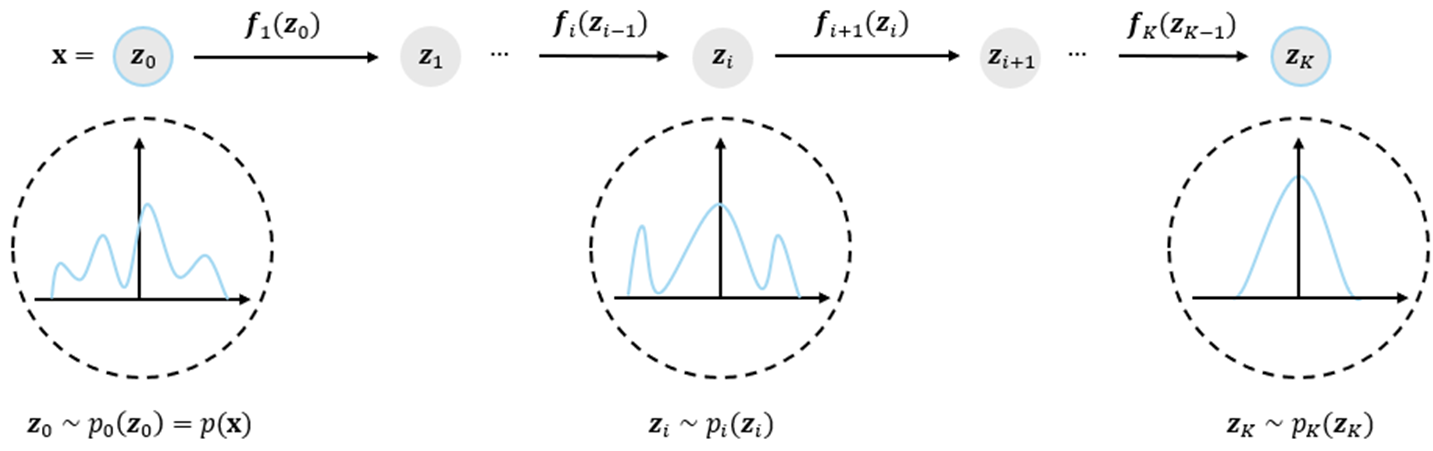

Основной проблемой в этом подходе является вычисление определителя якобиана. Поскольку мы работаем с композицией нескольких слоев, якобиан для всего преобразования $\boldsymbol{f}_{\boldsymbol{\theta}}$ является произведением Якобианов каждого из слоёв. 

Прямое вычисление определителя для произвольной матрицы имеет сложность $\mathcal{O}(D^3)$, где $D$ — размерность данных. Поэтому главная задача при разработке архитектур нормализующих потоков — это построение таких слоёв, для которых определитель якобиана можно было бы вычислять быстро, в идеале, за $\mathcal{O}(D)$.

### Функция потерь

функция потерь, которую мы минимизируем:

$$\mathcal{L}_{\boldsymbol{\theta}}(\mathbf{x})=-\log p_{\boldsymbol{\theta}}(\mathbf{x})= -\left( \log p(\mathbf{z}_K) + \sum_{k=1}^K \log \left| \ \det\left(\frac{\partial \boldsymbol{f}_{k,\boldsymbol{\theta}}}{\partial \mathbf{z}_{k-1}} \right) \right|\right)$$

- $\log p(\mathbf{z}_K)$ ​отвечает за то, чтобы выход потока $\boldsymbol{f}_{\boldsymbol{\theta}}(\mathbf{x})$ действительно соответствовал базовому распределению

- $​\sum_{k=1}^K \log \left| \ \det\left(\frac{\partial \boldsymbol{f}_{k,\boldsymbol{\theta}}}{\partial \mathbf{z}_{k-1}} \right) \right|$ отслеживает суммарное изменение объёма пространства после всех преобразований.

### Dataset MNIST

Для обучения поков мы будем использовать датасет `MNIST`. Он содержит $70000$ изображений рукописных цифр от $0$ до $9$:

- $60000$ изображений в тренировочном наборе

- $10000$ изображений в тестовом наборе

Каждое изображение размером $28\times 28$ пикселей, а метка — это целое число от $0$ до $9$, соответствующее изображённой цифре.

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

In [44]:
train_dataset = MNIST(root='./data', train=True, transform=transform)
val_dataset = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

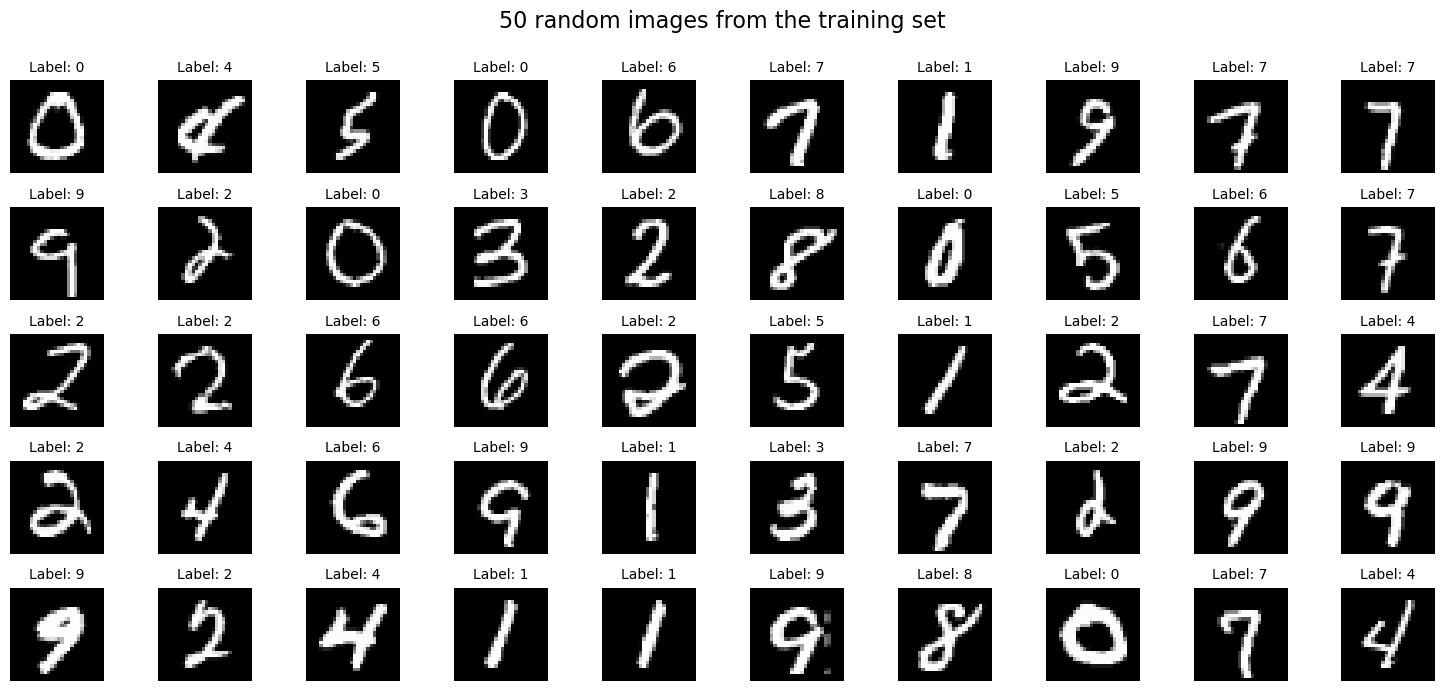

In [45]:
indices = random.sample(range(len(train_dataset)), 50)

images_labels = [train_dataset[i] for i in indices]
images, labels = zip(*images_labels)

images = [img.squeeze().numpy() * 0.5 + 0.5 for img in images]

fig, axes = plt.subplots(5, 10, figsize=(15, 7))
fig.suptitle('50 random images from the training set', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Label: {labels[i]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Модель NICE 

Модель **NICE** (**Non-linear Independent Components Estimation**), появившаяся в 2015 году, стала одним из первых значимых прорывов в области нормализующих потоков. 

Главная задумка NICE заключалась в том, чтобы упростить как прямое, так и обратное преобразование и сделать вычисление определителя Якобиана максимально быстрым — за константное время. Это достигалось за счет использования особого типа преобразований, которые назвали **аддитивными слоями связи** (**Additive coupling layers**).

### Additive Coupling Layers

Основным блоком модели NICE являются **аддитивные слои связи**. Каждый такой слой получает на вход вектор $\mathbf{x}$ и преобразует его в латентный вектор $\mathbf{z}$. Для этого входной вектор $\mathbf{x}$ сначала делится на две части $\mathbf{x}_{1:d}$ и $\mathbf{x}_{d+1:D}$, ​а затем преобразуется в выходной вектор $\mathbf{z}$ по следующим правилам:

$$\begin{cases} \mathbf{z}_{1:d} &= \mathbf{x}_{1:d} \\ \mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D} + m_{\boldsymbol{\theta}}(\mathbf{x}_{1:d}) \end{cases}$$

- В первую половину вектора $\mathbf{z}_{1:d}$ мы просто копируем вход $\mathbf{x}_{1:d}$
- Вторая половина вектора $\mathbf{z}_{d+1:D}$ становится суммой вектора $\mathbf{x}_{d+1:D}$ и выхода функции $m(⋅)$, которая принимает на вход первую половину входного вектора $\mathbf{x}_{1:d}$.

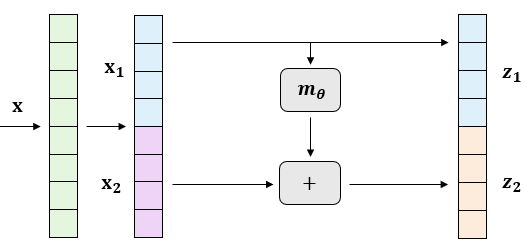

Такая архитектура легко обратима, поскольку обратное преобразование можно получить аналитически:

$$\begin{cases} \mathbf{x}_{1:d} &= \mathbf{z}_{1:d} \\ \mathbf{x}_{d+1:D} &= \mathbf{z}_{d+1:D} - m(\mathbf{z}_{1:d}) \end{cases}$$

Матрица Якоби для такого слоя имеет нижнетреугольный вид с единичными матрицами на диагонали:

$$\mathbf{J} = \begin{pmatrix} \mathbf{I}_d &\mathbf{0} \\ \frac{\partial \mathbf{z}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \mathbf{I}_{D-d} \end{pmatrix}$$

Определитель такой матрицы всегда равен единице.

In [46]:
class AdditiveCouplingLayer(nn.Module):
    def __init__(self, data_dim, hidden_dim, parity):
        super().__init__()
        # MLP to compute the additive shift 'm'
        self.m = nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2),
        )
        self.parity = parity

    def forward(self, x):
        if self.parity == 0:
            x1, x2 = x[:, ::2], x[:, 1::2]      # x1: even positions, x2: odd positions
        else:
            x1, x2 = x[:, 1::2], x[:, ::2]      # x1: odd positions, x2: even positions

        # Apply additive transformation to the active part
        z1 = x1                           
        z2 = x2 + self.m(x1)

        # Recombine in original positions
        z = torch.empty_like(x)
        if self.parity == 0:
            z[:, ::2] = z1                   # z1: even positions
            z[:, 1::2] = z2                  # z2: odd positions
        else:
            z[:, 1::2] = z1                  # z1: odd positions
            z[:, ::2] = z2                   # z2: even positions

        return z

    def inverse(self, z):
        if self.parity == 0:
            z1, z2 = z[:, ::2], z[:, 1::2]
        else:
            z1, z2 = z[:, 1::2], z[:, ::2]

        # Apply inverse of the additive transformation
        x1 = z1
        x2 = z2 - self.m(z1)  

        # Recombine in original positions
        x = torch.empty_like(z)
        if self.parity == 0:
            x[:, ::2] = x1
            x[:, 1::2] = x2
        else:
            x[:, 1::2] = x1
            x[:, ::2] = x2
        return x

### Diagonal Scaling Layer

Поскольку каждый **аддитивный слой связи имеет единичный определитель якобиана**, их композиция также будет иметь единичный определитель. Однако для моделирования сложных распределений нам нужно, чтобы преобразование могло изменять объем в пространстве латентных переменных.

Для решения этой проблемы после всех слоёв добавляется слой **диагонального масштабирования** (**Diagonal Scaling Layer**). Это преобразование выглядит как простое поэлементное умножение:

$$\mathbf{z} = \mathbf{s} \odot \mathbf{h}$$

где
- $\mathbf{h}$ — это выход последнего слоя связи
- $\mathbf{s}$ — это обучаемый вектор масштаба
- $\mathbf{z}$ — это итоговый латентный вектор

Определитель Якобиана для всей модели будет равен произведению всех элементов вектора $s$:
$$\det(\mathbf{J}) = \prod_{i=1}^D s_i$$

Тогда логарифм этого определителя, который нам нужен для функции потерь, будет просто суммой всех элементов $s$: 

$$\log|\det(\mathbf{J})| = \sum_{i=1}^D \log s_i$$

#### Практическая реализация

Все элементы вектора $s_i$ должны быть строго положительными. Чтобы гарантировать это условие во время обучения, на практике обучают не сам вектор $\mathbf{s}$, а его логарифм $\log\mathbf{s}$. Тогда реальный вектор масштаба вычисляется как $\mathbf{s}=e^{\log\mathbf{s}}$, что всегда обеспечивает положительные значения.

In [47]:
class DiagonalScalingLayer(nn.Module):
    def __init__(self, data_dim):
        super().__init__()
        self.s = nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        z = torch.exp(self.s) * x
        log_det = self.s.sum()
        return z, log_det

    def inverse(self, z):
        x = z / torch.exp(self.s)
        return x

### The final model

В оригинальной статье авторы предложили следующую архитектуру:

- **4 x Additive Coupling Layer**
- **Функция $m(\cdot)$ реализована в виде MLP с 5-ью скрытыми слоями.**
- **Каждый скрытый слой состоит из 1000 нейронов.**

In [48]:
class NICE(nn.Module):
    def __init__(self, num_layers, data_dim, hidden_dim):
        super().__init__()
        self.coupling_layers = nn.ModuleList([
            AdditiveCouplingLayer(data_dim, hidden_dim, parity=(i % 2))
            for i in range(num_layers)
        ])
        self.scaling_layer = DiagonalScalingLayer(data_dim)

    def forward(self, x):
       # Pass through all additive layers
        for layer in self.coupling_layers:
            x = layer(x)  # Each coupling layer is volume-preserving (log-det = 0)

        # Apply scaling and get its log-determinant
        z, log_det = self.scaling_layer(x)
        return z, log_det

    def inverse(self, z):
        # Apply the inverse scaling
        x = self.scaling_layer.inverse(z)

        # Pass through all coupling layers in reverse order
        for layer in reversed(self.coupling_layers):
            x = layer.inverse(x)
        return x

### Априорное распределение

В оригинальной статье NICE в качестве априорного распределения было выбрано стандартное многомерное логистическое распределение:

$$\log p(z_i) = -\log(1+e^{z_i}) - \log(1+e^{-z_i})$$

Авторы отметили, что логистическое распределение обеспечивает лучшее поведение градиентов в процессе обучения, что важно при обучении глубоких сетей.

В `Pytorch` нет реализации этого распределение, поэтому будем использовать **Inverse Transform Sampling** — способ генерации случайных чисел практически из любого распределения.

In [49]:
class StandardLogisticDistribution:
    def __init__(self, data_dim, device):

        self.m = TransformedDistribution(
            Uniform(
                torch.zeros(data_dim, device=device),
                torch.ones(data_dim, device=device)
            ),
            [
                SigmoidTransform().inv,
                AffineTransform(
                    loc=torch.zeros(data_dim, device=device),
                    scale=torch.ones(data_dim, device=device)
                )
            ]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self, n):
        return self.m.sample((n,))

In [50]:
@torch.no_grad()
def sample(model, base_dist, device, n_samples=5):
    model.eval()
    z = base_dist.sample(n_samples).to(device)
    x = model.inverse(z)
    return x.cpu()

def plot_images(images, data_dim, title="Generated Images"):
    if images.min() < 0:
        images = (images * 0.5 + 0.5)
    
    n_samples = images.shape[0]
    side = int(np.sqrt(data_dim))
    img_shape = (side, side)
    images = images.view(n_samples, *img_shape)

    max_in_row = 10 
    
    if n_samples <= max_in_row:
        rows, cols = 1, n_samples
        figsize = (2 * cols, 2.5 * rows)
    else:
        rows = int(np.ceil(n_samples / max_in_row))
        cols = max_in_row
        figsize = (2 * cols, 2.2 * rows)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title)

    axes_flat = axes.flat if n_samples > 1 else [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_samples:
            ax.imshow(images[i], cmap="gray", vmin=0.0, vmax=1.0)
        
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92 if title else 1.0) 
    plt.show()

### Training and Validation Loop

In [51]:
def train(model, optimizer, train_loader, base_dist, device):
    model.train()
    total_loss = 0.0

    for batch_x, _ in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.view(batch_x.size(0), -1).to(device)

        optimizer.zero_grad()

        z, log_det = model(x)  
        log_prob = base_dist.log_pdf(z) + log_det
        loss = -log_prob.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


@torch.no_grad()
def validate(model, val_loader, base_dist, device):
    model.eval()
    total_loss = 0.0

    for batch_x, _ in tqdm(val_loader, desc="Val", leave=False):
        x = batch_x.view(batch_x.size(0), -1).to(device)

        z, log_det = model(x)
        log_prob = base_dist.log_pdf(z) + log_det
        loss = -log_prob.mean()

        total_loss += loss.item()

    return total_loss / len(val_loader)


def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [52]:
def train_and_validate(model, optimizer, train_loader, val_loader, base_dist, num_epochs, device, sample_every=1):
    model = model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        avg_train = train(model, optimizer, train_loader, base_dist, device)
        avg_val = validate(model, val_loader, base_dist, device)
    
        train_losses.append(avg_train)
        val_losses.append(avg_val)
    
        plot_losses(train_losses, val_losses)

        if sample_every and (epoch % sample_every == 0):
            samples = sample(model, base_dist, device=device, n_samples=5)
            plot_images(samples, data_dim)

    
        print(f"[Epoch {epoch}/{num_epochs}] Train: {avg_train:.4f} | Val: {avg_val:.4f}")

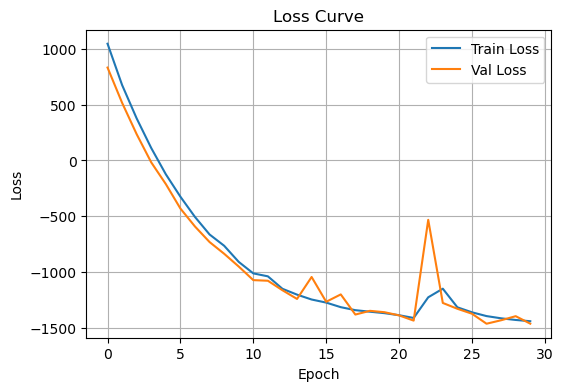

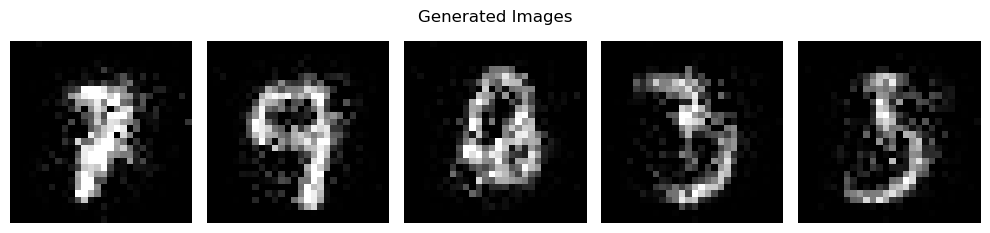

[Epoch 30/30] Train: -1437.7257 | Val: -1459.6579


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dim = 28 * 28
hidden_dim = 1000
num_layers = 4
num_epochs = 30
lr = 1e-3

model = NICE(num_layers=num_layers, data_dim=data_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
base_dist = StandardLogisticDistribution(data_dim=data_dim, device=device)

train_and_validate(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    base_dist=base_dist,
    num_epochs=num_epochs,
    device=device
)

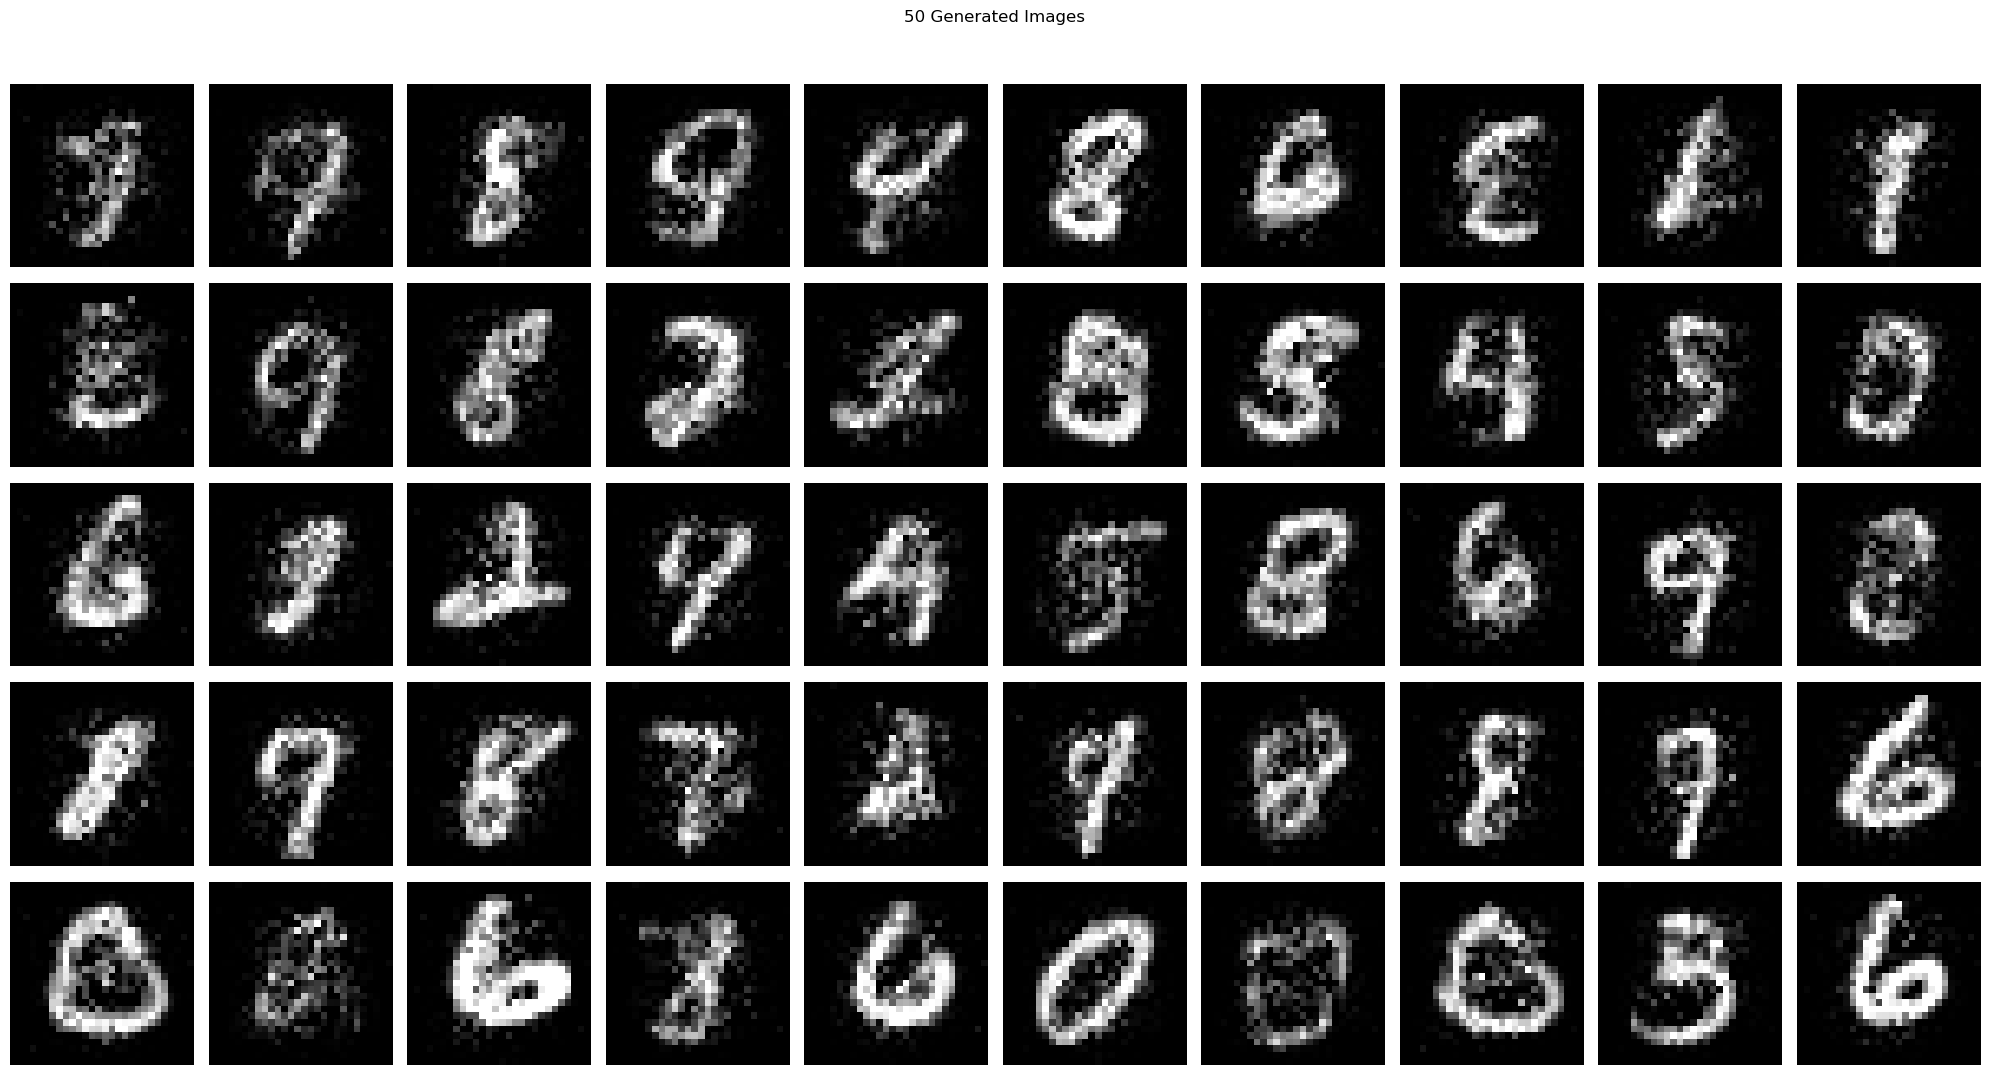

In [55]:
samples = sample(model, base_dist, device, n_samples=50)
plot_images(samples, data_dim, title="50 Generated Images")

## RealNVP

Модель RealNVP была сделана как более мощная версия NICE. Вместо аддитивных слоёв здесь стали использовать **аффинные связующие слои** (**Affine coupling layers**). 

Их основная идея такая же, как и в аддитивном слое NICE. Мы разделяем входной вектор $\mathbf{x}$ на две части $\mathbf{x}_{1:d}$ и $\mathbf{x}_{d+1:D}$. Первая часть остаётся без изменений, а вторая преобразуется с помощью функций, зависящих от первой части:

$$\begin{cases} \mathbf{z}_{1:d} &= \mathbf{x}_{1:d} \\ \mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D}\odot e^{s(\mathbf{x}_{1:d})} + t(\mathbf{x}_{1:d}) \end{cases}$$ 

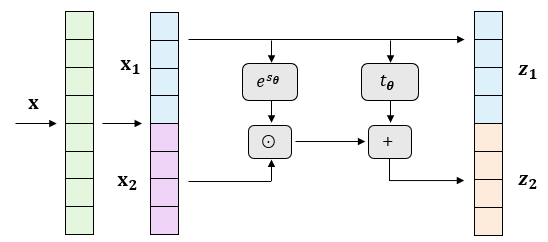

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform)
val_dataset = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

### Weight Normalization

В RealNVP для повышения стабильности обучения и ускорения сходимости используется **нормализация весов** (**Weight Normalization**). В отличие от **Batch Normalization**, которая работает с активациями нейронов (выходами слоев), **Weight_Norm** напрямую перепараметризует веса слоя.

Основная идея метода заключается в разделении весов $\mathbf{w}$ слоя на два независимых параметра:

- Скаляр $g$ - обучаемый параметр, отвечающий за величину весов.

- Вектор направления $\mathbf{v}$ — обучаемый вектор, отвечающий за направление весов.

Изначальные веса $\mathbf{w}$ вычисляются по формуле:

$$\mathbf{w} = g \frac{\mathbf{v}}{||\mathbf{v}||}$$

$||\mathbf{v}||$ - норма вектора $\mathbf{v}$

В процессе обучения нейросеть обновляет не $\mathbf{w}$ напрямую, а параметры $g$ и $\mathbf{v}$ по отдельности с помощью градиентного спуска, что делает процесс обучения более стабильным.

`WeightNorm` работает с весами, поэтому он не зависит от статистики батча, что делает его хорошим выбором для работы с маленькими батчами. 

In [57]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)

print("--- Standard Convolutional Layer ---")
for name, param in conv_layer.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

--- Standard Convolutional Layer ---
Parameter: weight, Shape: torch.Size([16, 3, 3, 3])
Parameter: bias, Shape: torch.Size([16])


In [58]:
wn_conv_layer = nn.utils.weight_norm(conv_layer)

print("\n--- Layer with Weight Normalization ---")
for name, param in wn_conv_layer.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")


--- Layer with Weight Normalization ---
Parameter: bias, Shape: torch.Size([16])
Parameter: weight_g, Shape: torch.Size([16, 1, 1, 1])
Parameter: weight_v, Shape: torch.Size([16, 3, 3, 3])


Несмотря на то, что обучаемые параметры изменились, выходной тензор остается прежним, то есть `weight_norm` — это просто способ перепараметризации, который не меняет логику вычислений.

In [59]:
x = torch.randn(1, 3, 32, 32)

output_original = conv_layer(x)
output_wn = wn_conv_layer(x)

print("\n--- Output Verification ---")
print(f"Outputs are close: {torch.allclose(output_original, output_wn)}")
print(f"Difference: {torch.norm(output_original - output_wn):.6f}")


--- Output Verification ---
Outputs are close: True
Difference: 0.000000


Создадим собственный класс-обертку, который будет состоять из сверточного слоя с нормализацией весов.

In [60]:
class WNConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super(WNConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias))

    def forward(self, x):
        x = self.conv(x)
        return x

### ResNet блок

Функции масштаба $s$ и сдвига $t$ в `RealNVP` должны быть достаточно сложными, чтобы моделировать сложные зависимости, поэтому авторы решили использовать ResNet-блоки. 

В реализации каждый `ResNetBlock` состоит из двух свёрточных слоёв, при этом между ними и на выходе применяется `BatchNorm2d` и функция активации `ReLU`.

#### Примечание об измененном Batch Norm

В оригинальной статье RealNVP авторы предложили специальный вариант `BatchNorm` для повышения стабильности обучения с очень маленькими батчами. Суть их метода заключалась в использовании сглаженных скользящих средних для нормализации вместо "шумных" статистик текущего батча. 

In [61]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.in_conv = WNConv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.out_conv = WNConv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        skip = x

        x = F.relu(x)
        x = self.in_conv(x)

        x = F.relu(x)
        x = self.out_conv(x)

        x = x + skip

        return x

### ResNet сеть

Чтобы функции масштабирования $s$ и сдвига $t$ были достаточно мощными и смогли уловить сложные зависимости в данных, в `RealNVP` используется не один, а несколькиз `ResNet` блоков.

In [62]:
class ResNet(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels,
                 num_blocks, kernel_size, padding, double_after_norm):
        super(ResNet, self).__init__()
        self.double_after_norm = double_after_norm
        self.in_conv = WNConv2d(2 * in_channels, mid_channels, kernel_size, padding, bias=True)
        self.in_skip = WNConv2d(mid_channels, mid_channels, kernel_size=1, padding=0, bias=True)

        self.blocks = nn.ModuleList([ResidualBlock(mid_channels, mid_channels)
                                     for _ in range(num_blocks)])
        self.skips = nn.ModuleList([WNConv2d(mid_channels, mid_channels, kernel_size=1, padding=0, bias=True)
                                    for _ in range(num_blocks)])

        self.out_conv = WNConv2d(mid_channels, out_channels, kernel_size=1, padding=0, bias=True)

    def forward(self, x):
        if self.double_after_norm:
            x *= 2.
        x = torch.cat((x, -x), dim=1)
        x = F.relu(x)
        x = self.in_conv(x)
        x_skip = self.in_skip(x)

        for block, skip in zip(self.blocks, self.skips):
            x = block(x)
            x_skip += skip(x)

        x = F.relu(x_skip)
        x = self.out_conv(x)

        return x

### Rescale Layer

Rescale — это простой слой, который обеспечивает стабильность и гибкость аффинных слоев связи.

Проблема в том, что параметр масштаба $s$ используется в виде $e^s$, что может легко привести к неустойчивым значениям и замедлить обучение.

Для решения этой проблемы используется двухэтапный подход:

- Сначала выход нейросети, предсказывающей $s$, пропускается через функцию `tanh`, которая сжимает значения в диапазон $[-1, 1]$.

- Затем слой `Rescale` умножает этот результат на свой обучаемый параметр `weight` для каждого канала.

In [63]:
class Rescale(nn.Module):
    def __init__(self, num_channels):
        super(Rescale, self).__init__()
        self.weight = nn.Parameter(torch.ones(num_channels, 1, 1))

    def forward(self, x):
        x = self.weight * x
        return x

### Affine coupling layer

В RealNVP для разделения входных данных используются две основные стратегии:

- **Пространственное разделение** (**Spatial Partitioning**): здесь разделение происходит на уровне пикселей.

- **Канальное разделение** (**Channel-wise Partitioning**): в этом случае тензор делится пополам вдоль оси каналов.

Как правило, в многомасштабной архитектуре эти подходы комбинируются: **шахматная маска** эффективна на первых уровнях с большим пространственным разрешением, а канальная — на более глубоких, где количество каналов велико.

Функция `checkerboard_mask` создаёт бинарную маску, где пиксели с чётной суммой координат $(i+j)$ получают значение $1$, а с нечётной — $0$.

In [64]:
def checkerboard_mask(h, w, invert=False, device=None, dtype=torch.float32):
    rows = torch.arange(h, device=device).view(-1, 1)  # (H, 1)
    cols = torch.arange(w, device=device).view(1, -1)  # (1, W)
    
    mask = (rows + cols) % 2
    if invert:
        mask = 1 - mask
    return mask.to(dtype).unsqueeze(0).unsqueeze(0)

В зависимости от того, как мы разделяем данные, мы используем разные типы маскирования.
Выбор типа маскирования зависит от того, на каком уровне абстракции работает слой:

- **`checkerboard`**: шахматная маска используется на самых ранних этапах многомасштабной архитектуры, она разделяет данные по пространственному расположению пикселей, что позволяет моделировать локальные зависимости.

- **`channel_wise`**: маска по каналам используется на более поздних этапах, после операции `Squeeze`, она разделяет тензор по каналам, что позволяет модели сосредоточиться на связях между различными признаками.

In [ ]:
class MaskType(IntEnum):
    CHECKERBOARD = 0
    CHANNEL_WISE = 1

class CouplingLayer(nn.Module):
    def __init__(self, in_channels, mid_channels, num_blocks, mask_type, reverse_mask):
        super(CouplingLayer, self).__init__()
        self.mask_type = mask_type
        self.reverse_mask = reverse_mask

        st_in_channels = in_channels
        if self.mask_type == MaskType.CHANNEL_WISE:
            st_in_channels //= 2

        self.st_net = ResNet(st_in_channels, mid_channels, 2 * st_in_channels,
                     num_blocks=num_blocks, kernel_size=3, padding=1,
                     double_after_norm=(self.mask_type == MaskType.CHECKERBOARD))
        self.rescale = nn.utils.weight_norm(Rescale(st_in_channels))

    def forward(self, x, sldj):
        if self.mask_type == MaskType.CHECKERBOARD:
            b = checkerboard_mask(x.size(2), x.size(3), self.reverse_mask, device=x.device)
            x_id = x * (1 - b)
            st = self.st_net(x_id)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))
            s = s * b
            t = t * b

            exp_s = s.exp()
            x = (x + t) * exp_s
            sldj += s.reshape(s.size(0), -1).sum(-1)
        else: # CHANNEL_WISE
            if self.reverse_mask:
                x_id, x_change = x.chunk(2, dim=1)
            else:
                x_change, x_id = x.chunk(2, dim=1)

            st = self.st_net(x_id)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))

            exp_s = s.exp()
            x_change = (x_change + t) * exp_s
            sldj += s.reshape(s.size(0), -1).sum(-1)

            if self.reverse_mask:
                x = torch.cat((x_id, x_change), dim=1)
            else:
                x = torch.cat((x_change, x_id), dim=1)

        return x, sldj

    def inverse(self, z):
        if self.mask_type == MaskType.CHECKERBOARD:
            b = checkerboard_mask(z.size(2), z.size(3), self.reverse_mask, device=z.device)
            z_id = z * (1 - b)
            st = self.st_net(z_id)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))
            s = s * b
            t = t * b

            inv_exp_s = s.mul(-1).exp()
            z = z * inv_exp_s - t
        else: # CHANNEL_WISE
            if self.reverse_mask:
                z_id, z_change = z.chunk(2, dim=1)
            else:
                z_change, z_id = z.chunk(2, dim=1)
            
            st = self.st_net(z_id)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))

            inv_exp_s = s.mul(-1).exp()
            z_change = z_change * inv_exp_s - t
            
            if self.reverse_mask:
                z = torch.cat((z_id, z_change), dim=1)
            else:
                z = torch.cat((z_change, z_id), dim=1)

        return z

### Multi-Scale архитектура

Модель строится рекурсивно, где каждый `RealNVPBlock` обрабатывает свой масштаб. На каждом уровне входной тензор проходит через несколько слоёв связи с шахматным маскированием, затем сжимается (`Squeeze`), снова проходит через слои с поканальным маскированием и снова сжимается.

### Squeeze

Класс `Squeeze` реализует операцию сжатия. Он преобразует тензор размера $(B, C, H, W) \longrightarrow (B, 4C, \frac{H}{2}, \frac{W}{2})$, "перекладывая" пространственную информацию в каналы. Это позволяет последующим слоям с канальными масками работать с более глобальными признаками. Обратная операция `inverse` восстанавливает исходную размерность.

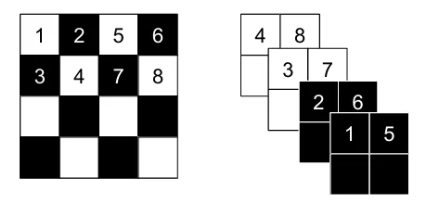

In [65]:
class Squeeze2x2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        b, c, h, w = x.size()
        assert h % 2 == 0 and w % 2 == 0
        
        x = x.view(b, c, h // 2, 2, w // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(b, c * 4, h // 2, w // 2)
        
        return x

    def inverse(self, x):
        b, c, h, w = x.size()
        assert c % 4 == 0
        
        x = x.view(b, c // 4, 2, 2, h, w)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(b, c // 4, h * 2, w * 2)
        
        return x

### Factoring out

Распространение D-мерного вектора через все связующие слои довольно громоздко с точки зрения вычислений и количества параметров модели. По этой причине после каждого `Multi-Scale` блока половина переменных выносится из основного потока и становится частью финального скрытого представления $\mathbf{z}$. Оставшаяся половина передаётся на следующие уровень, где процесс рекурсивно повторяется. Затем все вынесенные части объединяются в финальное скрытое представление $\mathbf{z}$.

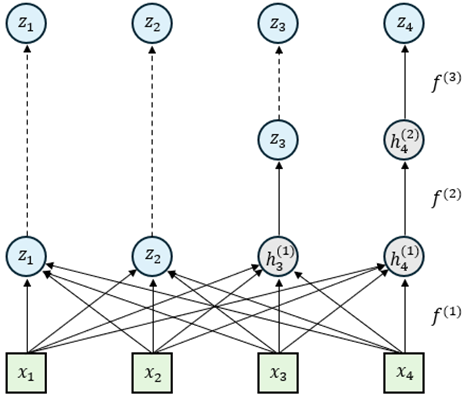

In [ ]:
class RealNVPBlock(nn.Module):
    def __init__(self, scale_idx, num_scales, in_channels, mid_channels, num_blocks):
        super(RealNVPBlock, self).__init__()
        self.is_last_block = scale_idx == num_scales - 1
        self.in_couplings = nn.ModuleList([
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=False),
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=True),
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=False)
        ])
        if self.is_last_block:
            self.in_couplings.append(
                CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=True))
        else:
            squeezed_channels = 4 * in_channels
            self.out_couplings = nn.ModuleList([
                CouplingLayer(squeezed_channels, 2*mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=False),
                CouplingLayer(squeezed_channels, 2*mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=True),
                CouplingLayer(squeezed_channels, 2*mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=False)
            ])
            self.squeeze = Squeeze2x2()
            self.next_block = RealNVPBlock(scale_idx + 1, num_scales, 2 * in_channels, 2 * mid_channels, num_blocks)

    def forward(self, x, sldj):
        for coupling in self.in_couplings:
            x, sldj = coupling(x, sldj)
        if self.is_last_block:
            return x, sldj
        x = self.squeeze(x)
        for coupling in self.out_couplings:
            x, sldj = coupling(x, sldj)
        x_next, z_split = x.chunk(2, dim=1)
        z_next, sldj = self.next_block(x_next, sldj)
        z = torch.cat((z_split, z_next), dim=1)
        return z, sldj

    def inverse(self, z):
        if self.is_last_block:
            for coupling in reversed(self.in_couplings):
                z = coupling.inverse(z)
            return z
        z_split, z_next = z.chunk(2, dim=1)
        x_next = self.next_block.inverse(z_next)
        x = torch.cat((x_next, z_split), dim=1)
        for coupling in reversed(self.out_couplings):
            x = coupling.inverse(x)
        x = self.squeeze.inverse(x)
        for coupling in reversed(self.in_couplings):
            x = coupling.inverse(x)
        return x

### Final Model

У реальных изображений и у нормального распределения есть два важных отличия:

1. **Тип данных**: пиксели — дискретные, нормальное распределение распределение — непрерывное.

2. **Диапазон значений**: пиксели ограничены диапазоном $[0, 1]$ (после нормализации), нормальное распределение определено на всей числовой прямой $(-\infty, + \infty)$.

Функции `_pre_process` и `_post_process` служат переходом между этими двумя мирами.

In [67]:
class RealNVP(nn.Module):
    def __init__(self, num_scales=2, in_channels=1, mid_channels=64, num_blocks=4):
        super(RealNVP, self).__init__()
        self.register_buffer('data_constraint', torch.tensor([0.9], dtype=torch.float32))
        self.flows = RealNVPBlock(0, num_scales, in_channels, mid_channels, num_blocks)

    def forward(self, x):
        x, sldj = self._pre_process(x)
        z, sldj = self.flows(x, sldj)
        return z, sldj

    def inverse(self, z):
        x_logit = self.flows.inverse(z)
        return self._post_process(x_logit)

    def _pre_process(self, x):
        y = (x * 255. + torch.rand_like(x)) / 256.         # Dequantization.
        y = (2 * y - 1) * self.data_constraint             # Scale and compress for numerical stability
        y = (y + 1) / 2
        y = y.log() - (1. - y).log()                       # Logit transform
        ldj = F.softplus(y) + F.softplus(-y) - F.softplus((1. - self.data_constraint).log() - self.data_constraint.log())
        return y, ldj.view(ldj.size(0), -1).sum(-1)

    def _post_process(self, z):
        x = torch.sigmoid(z)                                # Inverse logit transform
        x = 2 * x - 1
        x = x / self.data_constraint
        x = (x + 1) / 2
        return x

### Loss

In [ ]:
class RealNVPLoss(nn.Module):
    def __init__(self, k=256):
        super(RealNVPLoss, self).__init__()
        self.k = k

    def forward(self, z, log_det_sum):
        log_p_z = -0.5 * (z.pow(2) + np.log(2 * np.pi))             # Calculate log probability of z ~ N(0, I)
        log_p_z_sum = log_p_z.flatten(1).sum(1)

        dims = z.shape[1:].numel()
        dequant_corr = -np.log(self.k) * dims                       # Calculate dequantization correction.
        
        ll = log_p_z_sum + log_det_sum + dequant_corr               # Apply the change of variables formula to get log p(x)

        nll = -ll.mean()
        return nll

### Training and Validation Loop

In [69]:
def sample(net, batch_size, latent_shape, device):
    z = torch.randn((batch_size, *latent_shape), dtype=torch.float32, device=device)
    images = net.inverse(z) 
    return images

def plot_images(images, data_dim, title="Generated Images"):
   
    n_samples = images.shape[0]
    side = int(np.sqrt(data_dim))
    img_shape = (side, side)
    images = images.view(n_samples, *img_shape)

    max_in_row = 10
    
    if n_samples <= max_in_row:
        rows, cols = 1, n_samples
        figsize = (2 * cols, 2.5 * rows)
    else:
        rows = int(np.ceil(n_samples / max_in_row))
        cols = max_in_row
        figsize = (2 * cols, 2.2 * rows)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title)
    images_np = images.detach().cpu().numpy()
    axes_flat = axes.flat if n_samples > 1 else [axes]

    for i, ax in enumerate(axes_flat):
        if i < n_samples:
            ax.imshow(images_np[i], cmap="gray", vmin=0.0, vmax=1.0)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92 if title else 1.0)
    plt.show()

In [70]:
def train(model, optimizer, train_loader, loss_fn, device):
    model.train()
    total_loss = 0.0

    for batch_x, _ in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.to(device)
        optimizer.zero_grad()
        z, sldj = model(x)
        
        loss = loss_fn(z, sldj)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

@torch.no_grad()
def validate(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0

    for batch_x, _ in tqdm(val_loader, desc="Val", leave=False):
        x = batch_x.to(device)
        z, sldj = model(x)
        loss = loss_fn(z, sldj)
        total_loss += loss.item()

    return total_loss / len(val_loader)


def train_and_validate(model, optimizer, train_loader, val_loader, loss_fn,
                       num_epochs, device, latent_shape):
    model = model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        avg_train = train(model, optimizer, train_loader, loss_fn, device)
        avg_val = validate(model, val_loader, loss_fn, device)

        train_losses.append(avg_train)
        val_losses.append(avg_val)

        plot_losses(train_losses, val_losses)

        samples = sample(model, batch_size=5, latent_shape=latent_shape, device=device)
        plot_images(samples, data_dim=28*28)
        print(f"[Epoch {epoch}/{num_epochs}] Train: {avg_train:.4f} | Val: {avg_val:.4f}")

In [71]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-4
NUM_EPOCHS = 10

model = RealNVP(num_scales=2, in_channels=1, mid_channels=64, num_blocks=4)
model = model.to(DEVICE)

print(f"Количество параметров в модели: {sum(p.numel() for p in model.parameters())}")

loss_fn = RealNVPLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

Количество параметров в модели: 9843046


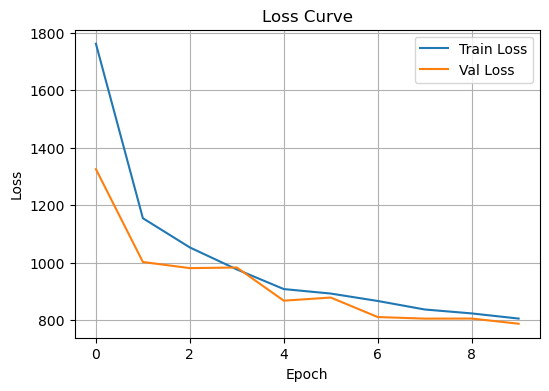

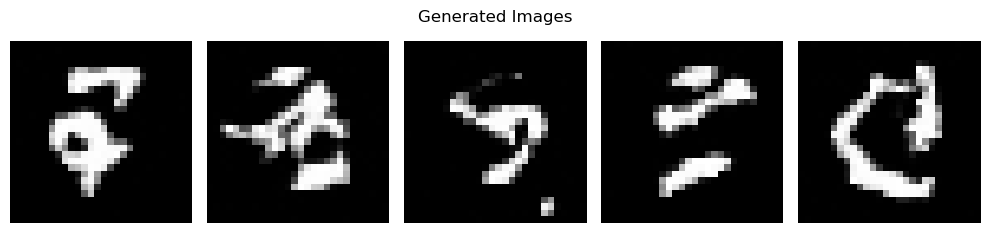

[Epoch 10/10] Train: 805.8851 | Val: 787.9828


In [72]:
LATENT_SHAPE = (4, 14, 14)

train_and_validate(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        latent_shape=LATENT_SHAPE
    )

In [73]:
image_shape=(1, 28, 28)
dummy_input = torch.zeros(1, *image_shape).to(DEVICE) 
model.eval()
with torch.no_grad():
    z_dummy, _ = model(dummy_input)
    latent_shape = z_dummy.shape[1:]

print(f"Image shape: {image_shape}")
print(f"Latent shape: {latent_shape}")

Image shape: (1, 28, 28)
Latent shape: torch.Size([4, 14, 14])


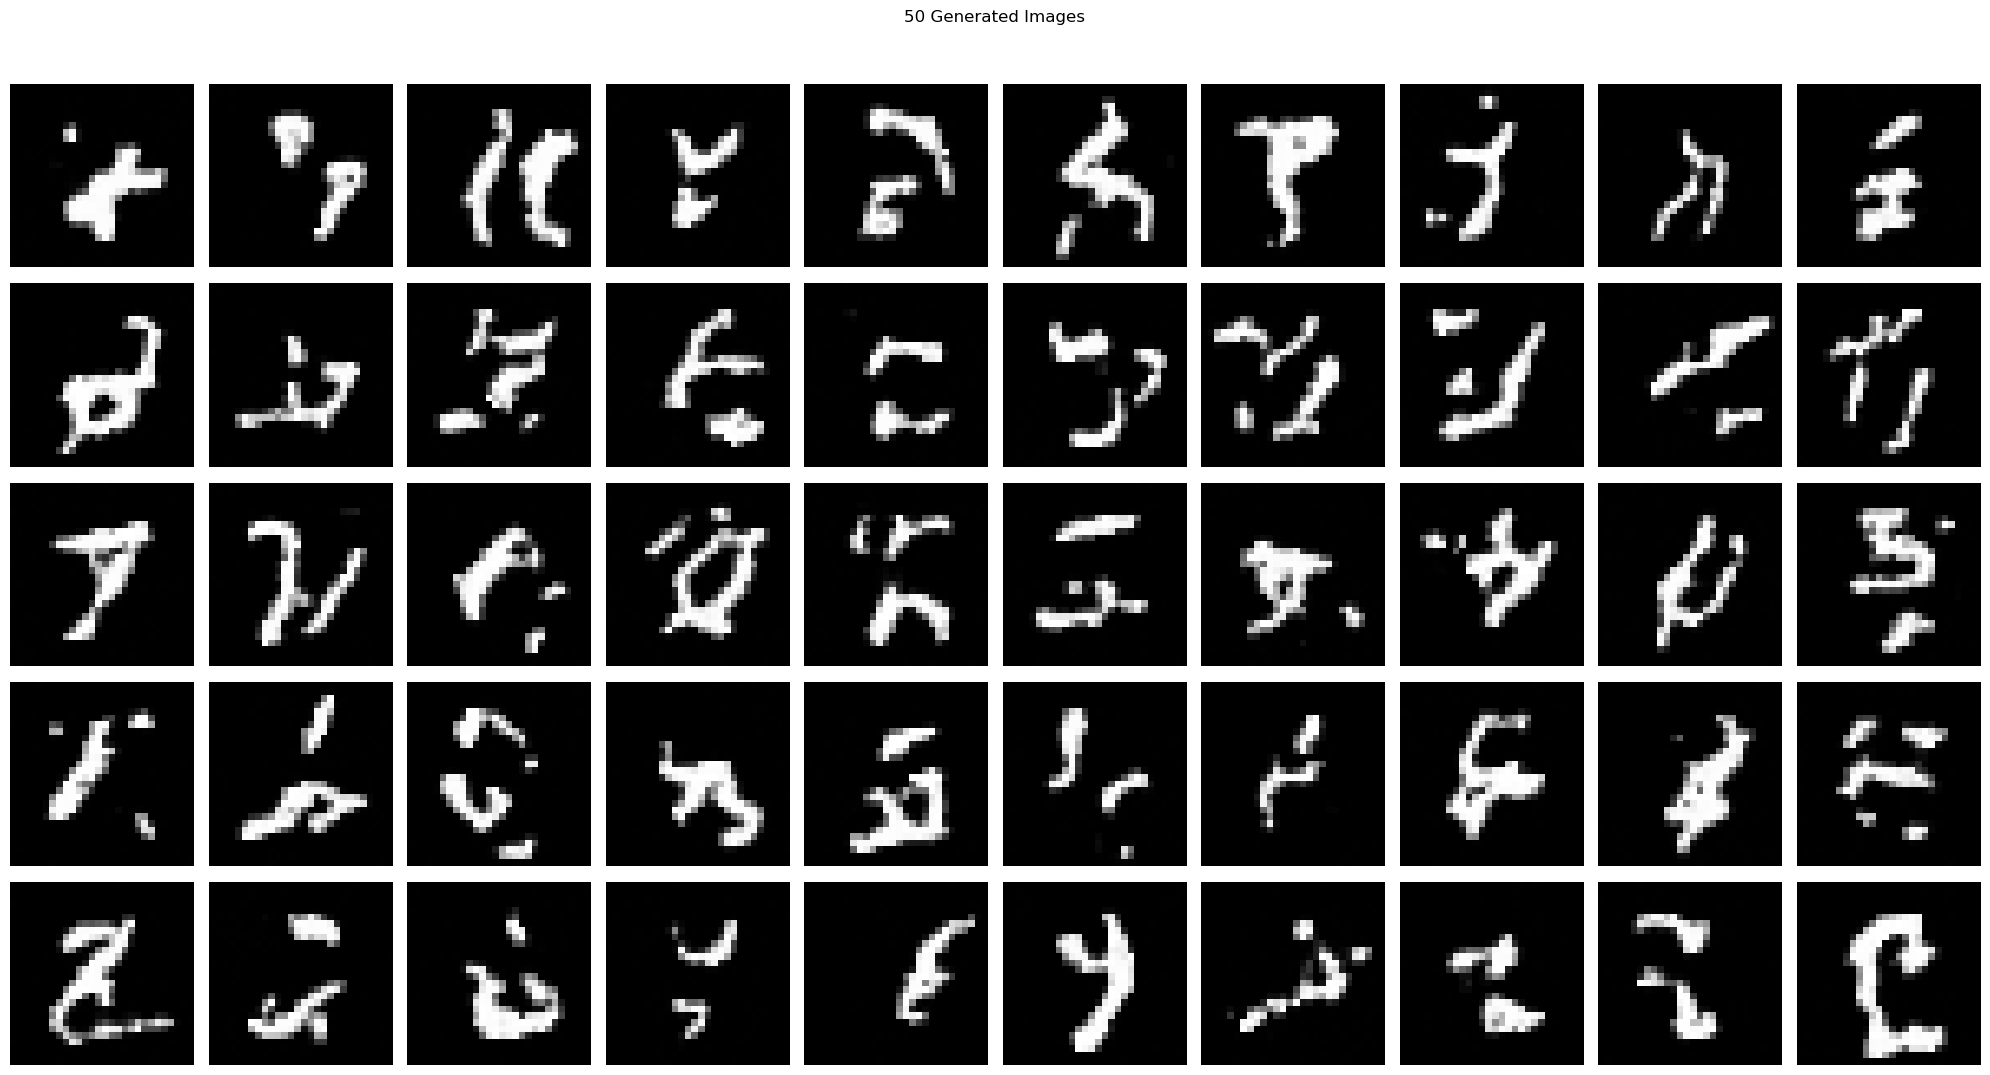

In [75]:
samples = sample(model, batch_size=50, latent_shape=LATENT_SHAPE, device=DEVICE)
plot_images(samples, data_dim=28*28, title="50 Generated Images")

### Latent Space

В нормализующих потоках мы можем исследовать их скрытое пространство.

Мы можем взять два разных изображения, получить их скрытые представления $\mathbf{z}_1$ и $\mathbf{z}_2$, а затем плавно пройти от $\mathbf{z}_1$ к $\mathbf{z}_2$ по прямой. Декодируя точки на этом пути, мы будем получать плавное визуальное превращение одного изображения в другое. Это показывает, что модель выучила не просто набор пикселей, а некую содержательную структуру данных.

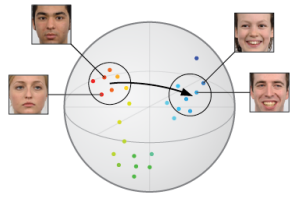

In [76]:
def interpolate(model, image1, image2, num_steps, device):
    model.eval() 
    with torch.no_grad():
        x1 = image1.unsqueeze(0).to(device)
        x2 = image2.unsqueeze(0).to(device)
        
        z1, _ = model(x1)
        z2, _ = model(x2)

        alphas = torch.linspace(0, 1, steps=num_steps, device=device)
        
        interpolated_z = []
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            interpolated_z.append(z_interp)
        
        interpolated_z = torch.cat(interpolated_z, dim=0)

        interpolated_images = model.inverse(interpolated_z)
                
    return interpolated_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021989822..1.009032].


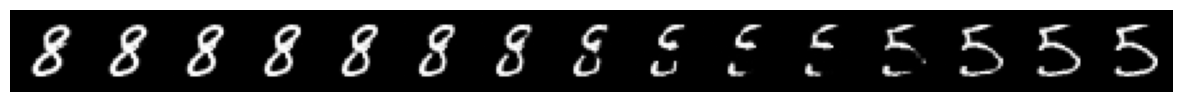

In [78]:
val_iter = iter(val_loader)
images, _ = next(val_iter)

img_a = images[110]
img_b = images[15]

interpolation_strip = interpolate(model, img_a, img_b, num_steps=15, device=DEVICE)

grid = make_grid(interpolation_strip.cpu(), nrow=15) 

plt.figure(figsize=(15, 3))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()